In [2]:
from jupyter_utils import jupyter_setup
jupyter_setup()
import numpy as np
import pandas as pd
import torch
from torch import nn
from torchvision.models import resnet18, resnet50, ResNet18_Weights, ResNet50_Weights
import matplotlib.pyplot as plt
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR
from torch.nn import InstanceNorm2d
# from utils.utils import ResidualInstanceNorm2d
from torchinfo import summary
from models import get_resnet18

D:\Archiv\Studium\Master\6.-Semester\Masters_Thesis\Git\acoustic_covid_detection\python


# Instance Normalization over each frequency separately
usually the instance norm normalizes over the two "image dimensions" meaning height and width or in our case frequency and time. So every channel has a parameter mean and variance with which it is normalied. In our special case, we want a nromalization across the channels and the time domain so that for every freqeuncy bin we get a mean and variance with which we can normalize the entire frequency bin (and every frequency bin separately<br>
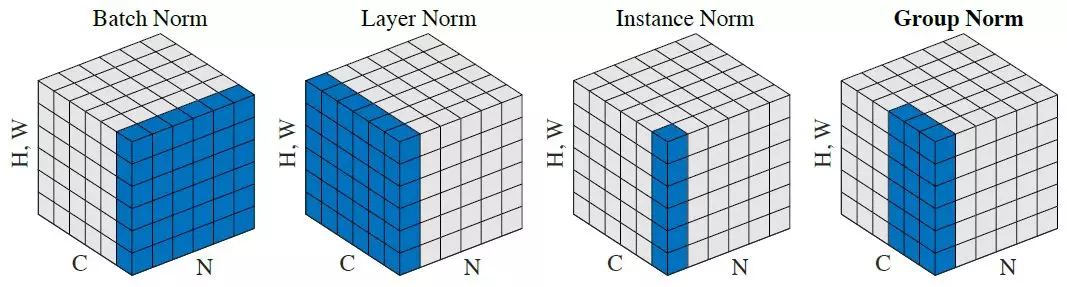
<br>
C...Channels, N...BatchSize, H&W...Height&Width(or Frequency and Time)

In [3]:
class Resnorm_selfmade(nn.Module):
    def __init__(self, gamma=1.0, eps=1e-5):
        super(Resnorm_v2, self).__init__()
        self.gamma = gamma
        self.eps = eps

    def forward(self, x):
        x_mean = x.mean(dim=[-3, -1], keepdim=True)
        x_var = x.var(dim=[-3, -1], keepdim=True, correction=0)
        
        x_normalized = (x - x_mean) / torch.sqrt(x_var + self.eps)
        
        out = x_normalized + self.gamma*x  # add residual connection
        return out

In [4]:
class ResidualInstanceNorm2d(nn.InstanceNorm2d):
    # using the pytorch implementation of the instance norm. this way, we can make use of affine and track running stats
    # gamma can be set to be a learnable parameter itself
    def __init__(self, num_features, gamma=1.0, eps=1e-5, momentum=0.1, affine=False, track_running_stats=False,
                 gamma_is_learnable=False):
        super(ResidualInstanceNorm2d, self).__init__(num_features=num_features, eps=eps, momentum=momentum,
                                                     affine=affine, track_running_stats=track_running_stats)
        if gamma_is_learnable:
            self.gamma = nn.Parameter(torch.tensor(float(gamma)))
        else:
            self.gamma = torch.tensor(float(gamma))

    def forward(self, x):
        # permute dimensions because we want to apply the normalization across the time and channel dimensions
        x = x.permute(0, 2, 3, 1).contiguous()
        # apply instance normalization
        x = super(ResidualInstanceNorm2d, self).forward(x)
        # permute dimensions back
        x = x.permute(0, 3, 1, 2).contiguous()
        x = x + self.gamma * x
        return x

# Adding Residual Norm into Resnet
after every batch norm layer in the main layers

In [5]:
my_model = resnet18(weights=ResNet18_Weights.DEFAULT)
N, C, F, T = 10, 3, 112, 224
# my_model

Getting the size of the frequency dimension after all the batch norm layers where i wnat to insert the resnorm layers. The num_features of the freq dim are mandatory for the instance norm if you want to use affine or track_running_stats

In [6]:
layers = summary(my_model, input_size=((N, C, F, T)))
layers = str(layers).split("\n")
layers = [layer for layer in layers if "BatchNorm2d: 3" in layer]
fdims = [int(layer.split("[")[1].split("]")[0].split(",")[2]) for layer in layers]
fdims

[28, 28, 28, 28, 14, 14, 14, 14, 7, 7, 7, 7, 4, 4, 4, 4]

In [10]:
layers = [my_model.layer1, my_model.layer2, my_model.layer3, my_model.layer4]
counter = 0
for layer in layers:
    for i in range(2):
        layer[i].bn1 = nn.Sequential(layer[i].bn1, ResidualInstanceNorm2d(num_features=fdims[counter], gamma=0.1, gamma_is_learnable=True, affine=False, track_running_stats=False))
        # print(fdims[counter])
        counter += 1

        layer[i].bn2 = nn.Sequential(layer[i].bn2, ResidualInstanceNorm2d(num_features=fdims[counter],  gamma=0.1, gamma_is_learnable=True, affine=False, track_running_stats=False))
        # print(fdims[counter])
        counter += 1

In [11]:
my_model(torch.rand(N, C, F, T))

tensor([[-3.0816, -0.6513, -0.6694,  ..., -1.2508,  0.3014,  1.6747],
        [-2.1956, -2.0901,  0.0809,  ..., -0.2562,  0.5388,  2.1028],
        [ 0.6498,  0.6192, -0.1716,  ...,  0.3673,  0.0837,  1.1619],
        ...,
        [-1.1226, -1.7027, -0.5027,  ...,  0.6677,  2.1369,  0.4714],
        [-2.9408, -2.7610, -1.5148,  ..., -1.3720, -0.6846,  1.9182],
        [-0.8149,  0.4748, -2.2152,  ..., -1.9089,  1.8249,  0.6794]],
       grad_fn=<AddmmBackward0>)